Load the data

In [1]:
import pandas as pd
#import matplotlib.pyplot as plt

#%matplotlib inline

#path = r"C:\Users\Surface\Masterarbeit\data\FEM_Daten\Baseline.xlsx"
path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_vorsortiert.xlsx"

df1 = pd.read_excel(path)
df = df1.drop(['time_stamp','C1_V01+C2_V01', 'C1_V01+C2_V02'], axis=1)

Transformation Pipeline

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#target = 'x_Einzug [mm]'
target = 'C1_V01_delta_kan'

# get the numerical features
data_num = df.drop(target, axis = 1)
# get the target values
data_labels = df[target].to_numpy()

# pipeline for preprocessing the data

# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

data_prep = data_pipeline.fit_transform(data_num)

X_temp, X_test, y_temp, y_test = train_test_split(data_prep, data_labels, test_size= 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size= 0.25, random_state=42)
print(data_prep.shape, X_train.shape, X_val.shape, X_test.shape)

(52013, 35) (31207, 35) (10403, 35) (10403, 35)


NGBoost for outputting Probalitiy Distribution instead of single value https://stanfordmlgroup.github.io/ngboost/1-useage.html

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


[iter 0] loss=3.4484 val_loss=3.4504 scale=1.0000 norm=6.1152
[iter 100] loss=3.1401 val_loss=3.1533 scale=1.0000 norm=4.5599
[iter 200] loss=2.9959 val_loss=3.0166 scale=2.0000 norm=7.9682
[iter 300] loss=2.8921 val_loss=2.9212 scale=1.0000 norm=3.6165
[iter 400] loss=2.8329 val_loss=2.8670 scale=1.0000 norm=3.4563
[iter 500] loss=2.7844 val_loss=2.8216 scale=2.0000 norm=6.6498
[iter 600] loss=2.7481 val_loss=2.7878 scale=1.0000 norm=3.2312
[iter 700] loss=2.7211 val_loss=2.7636 scale=1.0000 norm=3.1628
R² on Train Data: 0.733
R² on Test Data: 0.714
Coverage: 100.00%


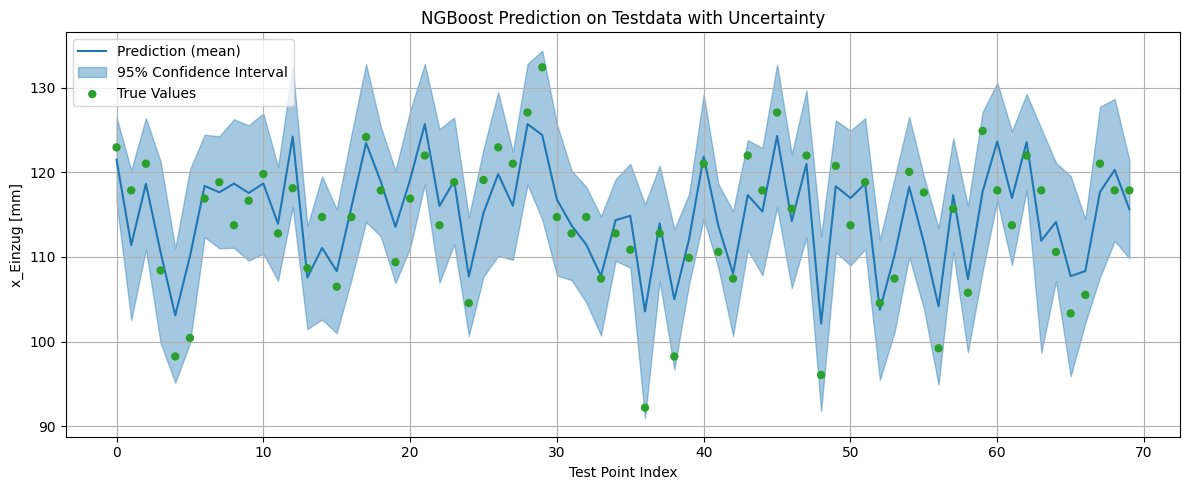

In [10]:
from ngboost import NGBRegressor
from ngboost.scores import LogScore
from ngboost.distns import  Normal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import wandb
wandb.login()

# first choice: normal distribution
# default base learner is a depth 3 decision tree
ngb = NGBRegressor(Dist=Normal, Score = LogScore, verbose = True, n_estimators=800, learning_rate=0.01)
# fit the model to the training data, early stopping on validation set after 2 rounds without improvement
ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=2)

# Predicte distribution for train and test data
y_dists_train = ngb.pred_dist(X_train)
y_dists_test = ngb.pred_dist(X_test)

# Extract mean and standard deviation from predictions
train_mean = y_dists_train.loc
train_stddev = y_dists_train.scale

# Calculate R² for the train data
r2_test = r2_score(y_train, train_mean)
print(f"R² on Train Data: {r2_test:.3f}")

# Extract mean and standard deviation from predictions
test_mean = y_dists_test.loc
test_stddev = y_dists_test.scale
true = y_test

# Calculate R² for the test data
r2_test = r2_score(true, test_mean)
print(f"R² on Test Data: {r2_test:.3f}")


# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
ngboost_lower = test_mean[:70] - 2*test_stddev[:70]
ngboost_upper = test_mean[:70] + 2*test_stddev[:70]

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (true[:70] >= ngboost_lower) & (true[:70] <= ngboost_upper)
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval]

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Plotting the prediction with uncertainty and true values
fig = plt.figure(figsize=(12, 5))
x_axis = np.arange(len(y_test[:70]))

# Plot predicted mean
plt.plot(x_axis, test_mean[:70], label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, ngboost_lower, ngboost_upper,
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, true[:70], label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("NGBoost Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# wandb.init(project="ngboost-fem-rauschen", config={
#     "n_estimators": 400,
#     "learning_rate": 0.01,
#     "distribution": "Normal",
#     "score": "LogScore",
#     "early_stopping_rounds": 2,
#     })

# wandb.log({"coverage": coverage})
# wandb.log({"R²": r2_test})
# wandb.log({"confidence_interval_plot": wandb.Image(fig)})

Overview on the feature importance

Text(0.5, 1.0, 'scale param')

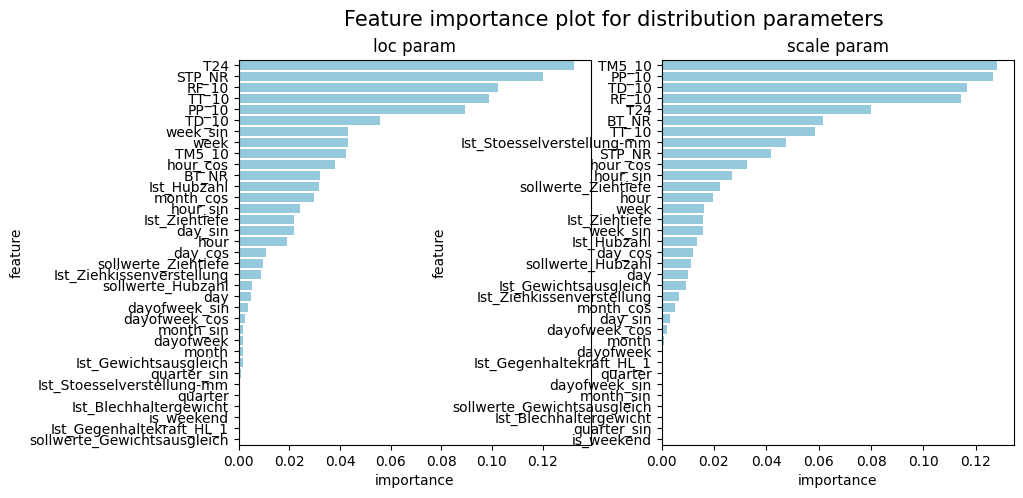

In [7]:
import seaborn as sns
## Feature importance for loc trees
feature_importance_loc = ngb.feature_importances_[0]

## Feature importance for scale trees
feature_importance_scale = ngb.feature_importances_[1]

features = data_num.columns
#['Matrizenradius [mm ]', 'Stempelkantenradius [mm]', 'Blechdicke [mm]',            'Platinenabmessung [mm]', '1/4 Niederhalterkraft [N]', 'Ziehtiefe [mm]']

df_loc = pd.DataFrame({
                        'feature':features,
                        'importance':feature_importance_loc})\
                        .sort_values('importance',ascending=False)
    
df_scale = pd.DataFrame({
                        'feature':features,
                        'importance':feature_importance_scale})\
                        .sort_values('importance',ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle("Feature importance plot for distribution parameters", fontsize=15)
sns.barplot(x='importance',y='feature',ax=ax1,data=df_loc, color="skyblue").set_title('loc param')
sns.barplot(x='importance',y='feature',ax=ax2,data=df_scale, color="skyblue").set_title('scale param')

Gradient Boosting Trees: Decision trees die Fehler korrigieren, Model besteht aus der Summer der einzelenen Modele

In [ ]:
import xgboost

# Initialize the XGBoost regressor
xgb_reg = xgboost.XGBRegressor()

# Fit the model to the training data
xgb_reg.fit(X_train, y_train)

#Get feature importances from the trained model
importances = xgb_reg.feature_importances_
features = ['Matrizenradius [mm ]', 'Stempelkantenradius [mm]', 'Blechdicke [mm]',
            'Platinenabmessung [mm]', '1/4 Niederhalterkraft [N]', 'Ziehtiefe [mm]']

# Create a DataFrame to display feature importance, sorted descending
xgb_feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

#show important features
display(xgb_feat_df)

#Make predictions on train and test set
y_train_pred = xgb_reg.predict(X_train)
y_test_pred = xgb_reg.predict(X_test)

#Calculate R² scores for train and test predictions
r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

#Compare R2 Score for the first 10 instances
vergleich_df = pd.DataFrame({
    'True value' : y_test[:10],
    'Prediction' : y_test_pred[:10].flatten(),
    'Difference' : y_test[:10] - y_test_pred[:10].flatten()
 })

#print the result
print(f'\nR² Train: {r2_train:.4f} | R² Test: {r2_test:.4f}')
display(vergleich_df.style.background_gradient(cmap='RdYlGn_r'))

,Feature,Importance
5,Ziehtiefe [mm],0.751322
1,Stempelkantenradius [mm],0.137467
3,Platinenabmessung [mm],0.106652
4,1/4 Niederhalterkraft [N],0.002644
0,Matrizenradius [mm ],0.001138
2,Blechdicke [mm],0.000776



R² Train: 1.0000 | R² Test: 0.9996


,True value,Prediction,Difference
0,6.590000,6.564295,0.025705
1,8.100000,8.071957,0.028043
2,9.231000,9.230880,0.000120
3,7.623000,7.612185,0.010815
4,9.253500,9.231865,0.021635
5,10.484500,10.455526,0.028974
6,8.219000,8.186750,0.032250
7,6.679500,6.698020,-0.018520
8,8.614500,8.596509,0.017991
9,7.534500,7.553208,-0.018708
